In [51]:
import lasio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sys import stdout
from openpyxl import Workbook


w1 = r'.\DATOS_EDITADOS\SNRG-0001_FINAL.las'
w2 = r'./Well_Logging/SNRG-0002_basic_logs.las'
w3 = r'./Well_Logging/SNRG-0003_basic_logs.las'
w4 = r'./Well_Logging/SNRG-0004_basic_logs.las'


In [53]:
las_1 = lasio.read(w1)
las_1.to_csv(stdout)
df = las_1.df()
df.reset_index(inplace =True)
# df.to_excel("Registro_4.xlsx",sheet_name="Registro_4_Limpio",index=False)

DEPTH,DDLL,BIT,DCOR,DEN,DSLL,DT35,GRGC,NPHI,NPRD,NPRL,NPRS,PDPE,TOC
FT,OHMM,MM,G/C3,G/C3,OHMM,US/F,GAPI,dec,PERC,PERC,PERC,B/E,%
0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7.5,nan,nan,nan,nan,nan,nan,nan

In [39]:
GR_max = df['GRGC'].max()
GR_min = df['GRGC'].min()

KeyError: 'GRGC'

In [14]:
print(GR_max," ",GR_min)

202.263   8.304


In [15]:
df.describe()

,DDLL,BIT,DCOR,DEN,DSLL,DT35,GRGC,NPHI,NPRD,NPRL,NPRS,PDPE,TOC
count,8220.000000,8220.000,8159.000000,8159.000000,8220.000000,8176.000000,8116.000000,8140.000000,8140.000000,8140.000000,8140.000000,8158.000000,19.000000
mean,4319.877358,7.875,0.091406,2.653141,6278.283751,58.338938,73.712321,0.093679,8.080486,9.367894,13.716096,3.655489,1.900000
std,17680.817080,0.000,0.071117,0.121233,21748.160774,10.305730,46.026915,0.067164,6.353251,6.716478,8.119133,0.602250,0.444697
min,2.731000,7.875,-0.072000,1.659000,3.540000,38.732000,8.304000,-0.000300,-0.913000,-0.034000,1.711000,2.091000,0.990000
25%,52.509000,7.875,0.040000,2.596000,49.984750,49.006750,27.804750,0.032200,2.262000,3.222750,6.246000,3.214000,1.555000
50%,149.712000,7.875,0.057000,2.673000,166.342500,56.669500,64.811500,0.073600,6.232000,7.355500,11.650000,3.580000,1.890000
75%,755.825250,7.875,0.124000,2.723000,762.695750,67.237750,120.141500,0.156600,14.050500,15.656250,21.487000,4.014000,2.360000
max,108535.085900,7.875,0.348000,2.907000,108302.007800,107.852000,202.263000,0.303300,27.574000,30.331000,35.937000,5.384000,2.440000


In [16]:
df.dtypes

DDLL    float64
BIT     float64
DCOR    float64
DEN     float64
DSLL    float64
DT35    float64
GRGC    float64
NPHI    float64
NPRD    float64
NPRL    float64
NPRS    float64
PDPE    float64
TOC     float64
dtype: object

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 18001 entries, 0.0 to 9000.0
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DDLL    8220 non-null   float64
 1   BIT     8220 non-null   float64
 2   DCOR    8159 non-null   float64
 3   DEN     8159 non-null   float64
 4   DSLL    8220 non-null   float64
 5   DT35    8176 non-null   float64
 6   GRGC    8116 non-null   float64
 7   NPHI    8140 non-null   float64
 8   NPRD    8140 non-null   float64
 9   NPRL    8140 non-null   float64
 10  NPRS    8140 non-null   float64
 11  PDPE    8158 non-null   float64
 12  TOC     19 non-null     float64
dtypes: float64(13)
memory usage: 1.9 MB


In [20]:
df.to_excel("Registro.xlsx",sheet_name="Registro_2_Limpio",index=False)

In [11]:
Gamma_Ray = df[['GR']]
Neutron = df['NPHI']
Resistive = df [['AORX','AO10','AO20']]


<AxesSubplot:>

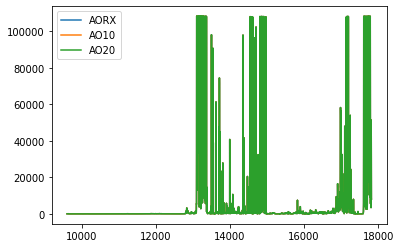

In [12]:
Resistive.plot()

<AxesSubplot:>

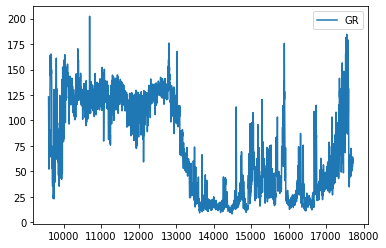

In [13]:
Gamma_Ray.plot()

<AxesSubplot:xlabel='TNPH', ylabel='DEPTH:1'>

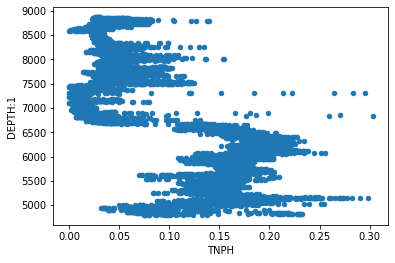

In [14]:
neutron_density = df[['DEPTH:1','TNPH','RHOZ']]
df.plot.scatter(x='TNPH',y='DEPTH:1',)

In [15]:
GR = df['GR']
IGR = (GR-GR_min)/(GR_max-GR_min)
Vsh = 1.7 - (3.38-(IGR+0.7)**2)**0.5
Vsh.head()
Vsh.shape



(18001,)

<AxesSubplot:xlabel='GR'>

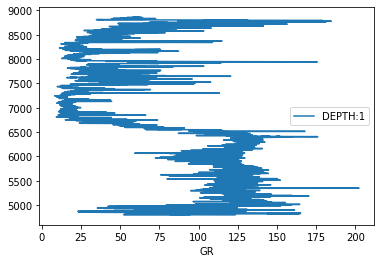

In [16]:
df.plot(x='GR',y='DEPTH:1')

<AxesSubplot:xlabel='NPHI'>

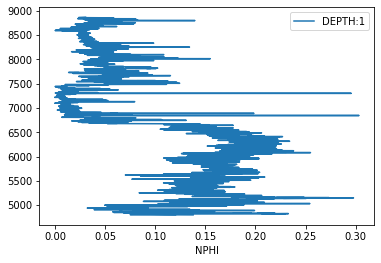

In [17]:
df.plot.line(x='NPHI',y='DEPTH:1')

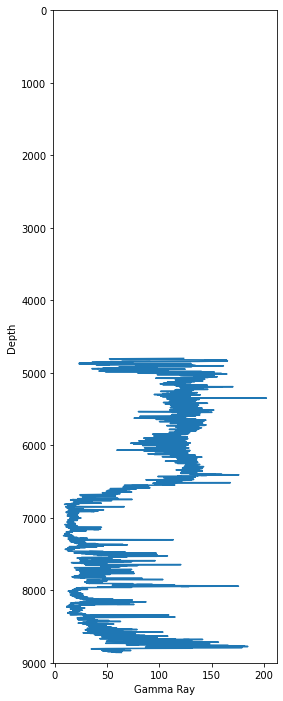

In [18]:
fig , axs = plt.subplots(figsize=(4,12))
plt.plot(df['GR'],df['DEPTH:1'])
plt.xlabel('Gamma Ray')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH:1']),min(df['DEPTH:1']))
fig.savefig("Gammaray.png")


C:\Users\camil\Documents\Sinergia 2021\venv\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


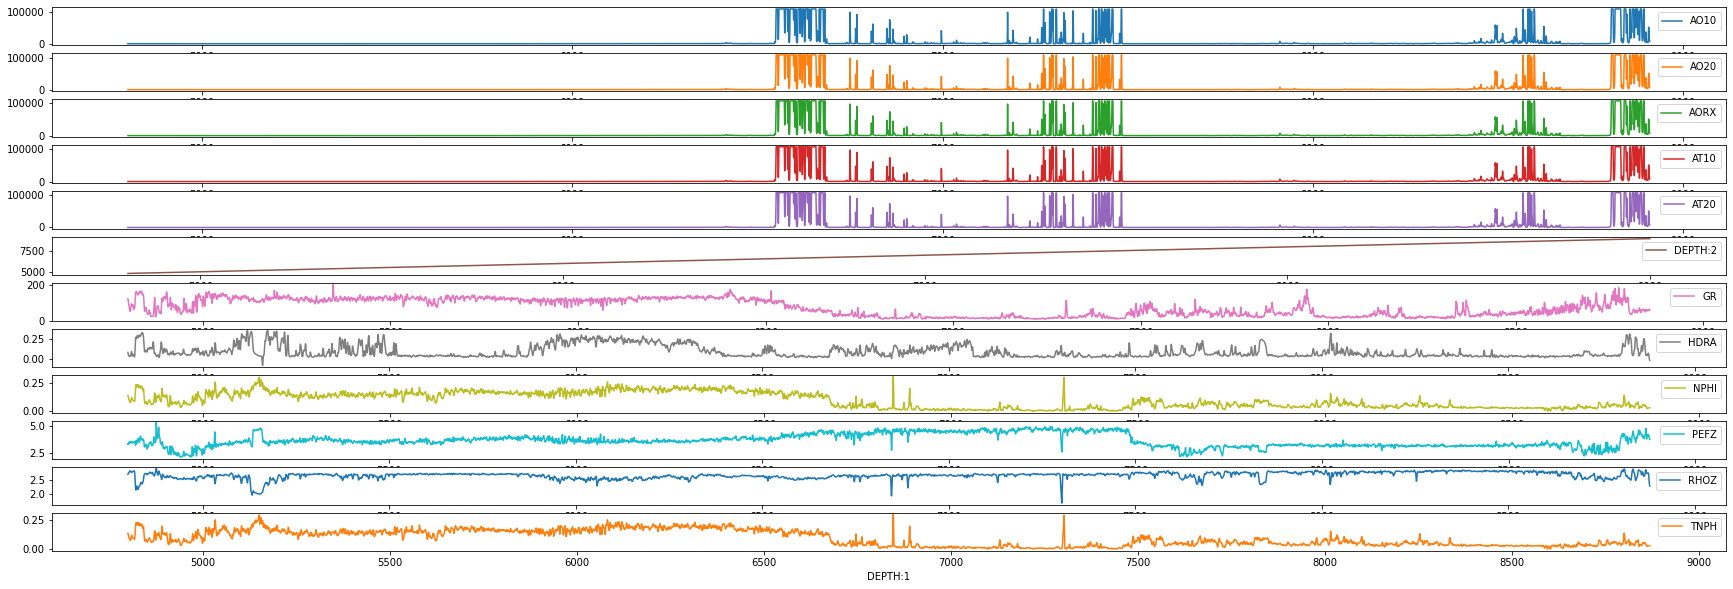

In [19]:
fig, axs = plt.subplots(figsize=(30,10))
df.plot(x='DEPTH:1',ax = axs,figsize=(30,10),subplots=True)
fig.savefig("Resumen de registros.png")

(9000.0, 0.0)

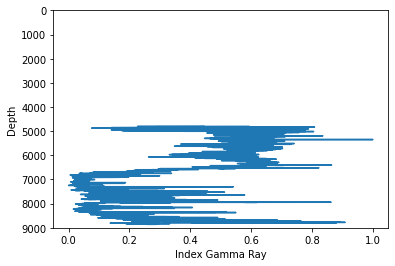

In [20]:
df['IGR'] = (df['GR']-GR_min)/(GR_max-GR_min)
df['Vshale'] = 1.7 - (3.38-(df['IGR']+0.7**2))**0.5
plt.plot(df['IGR'],df['DEPTH:1'])
plt.xlabel('Index Gamma Ray')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH:1']),min(df['DEPTH:1']))

(9000.0, 0.0)

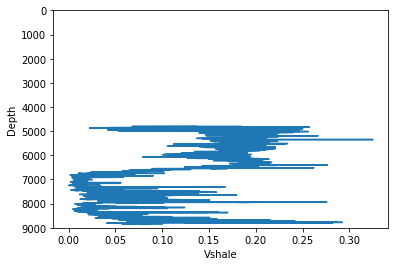

In [21]:
plt.plot(df['Vshale'],df['DEPTH:1'])
plt.xlabel('Vshale')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH:1']),min(df['DEPTH:1']))

In [22]:
# df.to_excel("Registro_1.xlsx",sheet_name="Registro_1",index=False)
df

,DEPTH:1,AO10,AO20,AORX,AT10,AT20,DEPTH:2,GR,HDRA,NPHI,PEFZ,RHOZ,TNPH,IGR,Vshale
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,8998.0,NaN,NaN,NaN,NaN,NaN,8998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17997,8998.5,NaN,NaN,NaN,NaN,NaN,8998.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17998,8999.0,NaN,NaN,NaN,NaN,NaN,8999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17999,8999.5,NaN,NaN,NaN,NaN,NaN,8999.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
